In [163]:
import pandas as pd
import numpy as np
data=pd.read_csv('005930.KS (1).csv')

In [164]:
data #2020-3-12부터 2023-3-12까지의 데이터를 다운받았다. 
#date와 open칼럼만 사용하기로  하자. 

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-03-12,52100.0,52100.0,52100.0,52100.0,47737.878906,0
1,2020-03-13,47450.0,51600.0,46850.0,49950.0,45767.882813,59462933
2,2020-03-16,50100.0,50900.0,48800.0,48900.0,44805.800781,33339821
3,2020-03-17,46900.0,49650.0,46700.0,47300.0,43339.761719,51218151
4,2020-03-18,47750.0,48350.0,45600.0,45600.0,41782.093750,40152623
...,...,...,...,...,...,...,...
734,2023-03-06,61100.0,61600.0,60800.0,61500.0,61500.000000,13630602
735,2023-03-07,61400.0,61400.0,60700.0,60700.0,60700.000000,11473280
736,2023-03-08,60100.0,60500.0,59900.0,60300.0,60300.000000,14161857
737,2023-03-09,60500.0,60800.0,59900.0,60100.0,60100.000000,14334499


In [165]:
data=data[['Date','Open']]

In [166]:
data.info() #날짜의 형태가 그냥 object이므로 날짜형식으로 바꾸어주자. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739 entries, 0 to 738
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    739 non-null    object 
 1   Open    739 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.7+ KB


In [167]:
data['Date'].value_counts() #각 날짜별로 한개의 값이 있는것을 

2020-03-12    1
2022-03-18    1
2022-03-04    1
2022-03-07    1
2022-03-08    1
             ..
2021-03-16    1
2021-03-17    1
2021-03-18    1
2021-03-19    1
2023-03-10    1
Name: Date, Length: 739, dtype: int64

In [168]:
data['Date'] = pd.to_datetime(data['Date'],format="%Y-%m-%d") #날짜형식으로 바꿔줌
data.set_index('Date', inplace=True) #date는 인덱스처리함
data.head(3)

C:\Users\diaky\AppData\Local\Temp\ipykernel_8040\3886546569.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'],format="%Y-%m-%d")


,Open
Date,
2020-03-12,52100.0
2020-03-13,47450.0
2020-03-16,50100.0


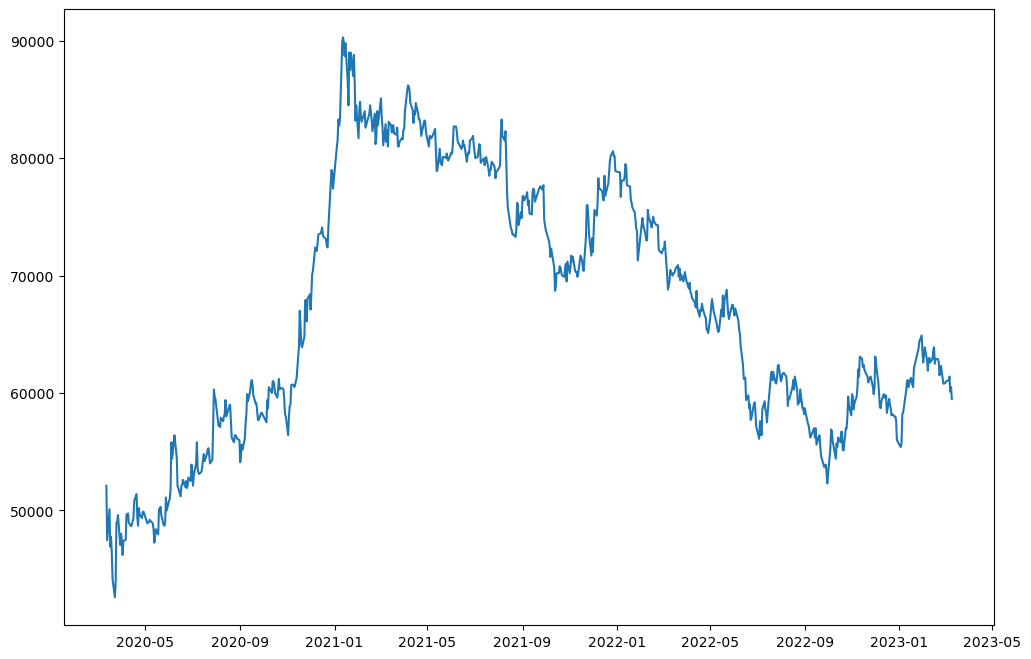

In [169]:
import matplotlib.pyplot as plt
plt.plot(data.index,data['Open'])
#데이터의 상태를 plot그린다. 
#계절성은 딱히 보이지 않는다.비정상성데이터 

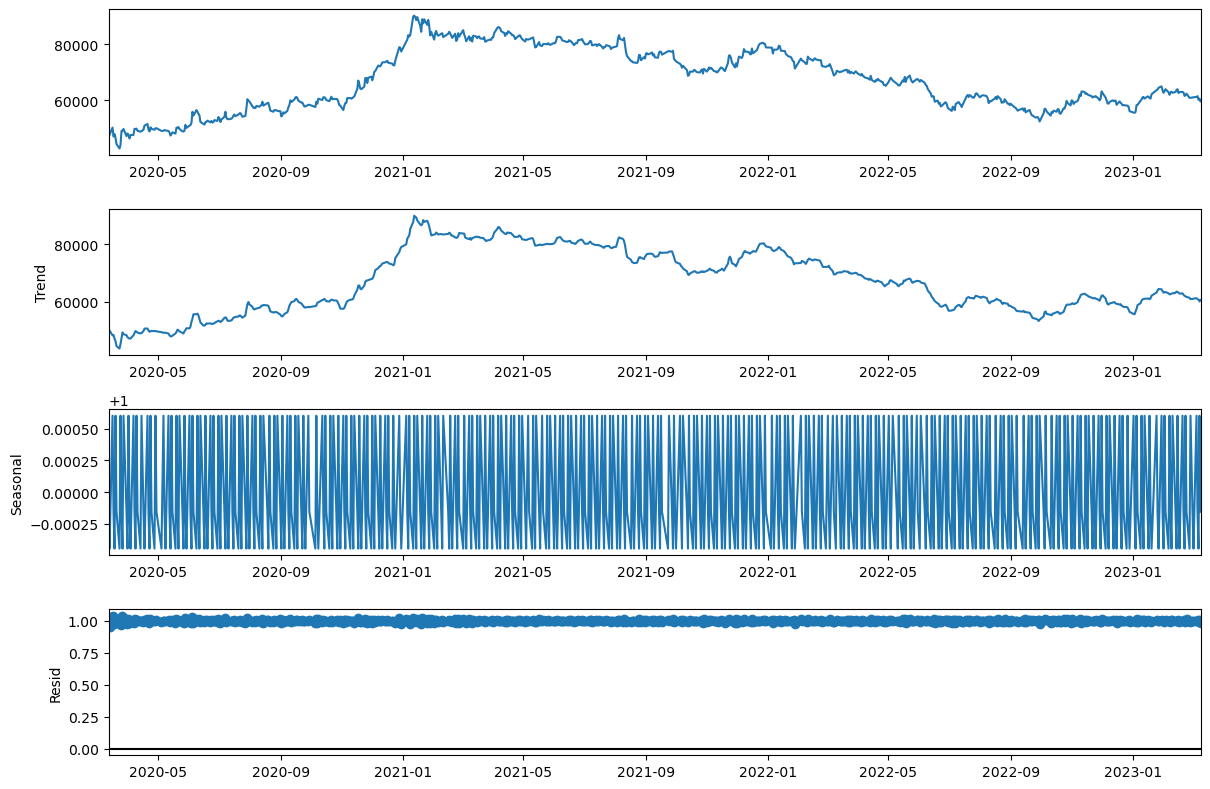

In [170]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts = data
result = seasonal_decompose(ts, model='multiplicative', extrapolate_trend=3,period=3)
plt.rcParams['figure.figsize'] = [12, 8]
result.plot()
plt.show()

In [171]:
from statsmodels.tsa.stattools import adfuller

#Train, Test 데이터 구분
training = data[:"2022-03-12"] #2021,2022데이터를 훈련데이터로 
test = data.drop(training.index)


adf = adfuller(training, regression='ct')
print('ADF Statistic: {}'.format(adf[0]))
print('p-value : {}'.format(adf[1]))
#adf의 pvalue가 0.05이상이므로 귀무가설을 기각할 수 없으므로 시계열이 안정적이지 않음을 보여줌. 

ADF Statistic: -1.168437474112336
p-value : 0.9167726362267531


In [172]:
from pmdarima.arima import ndiffs #차분을 몇번해야 가장 좋을지 구해보자. 
kpss_diffs = ndiffs(training, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(training, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d = {n_diffs}")#차분은 한번만 진행하는게 좋겠다. 

추정된 차수 d = 1


<AxesSubplot:xlabel='Date'>

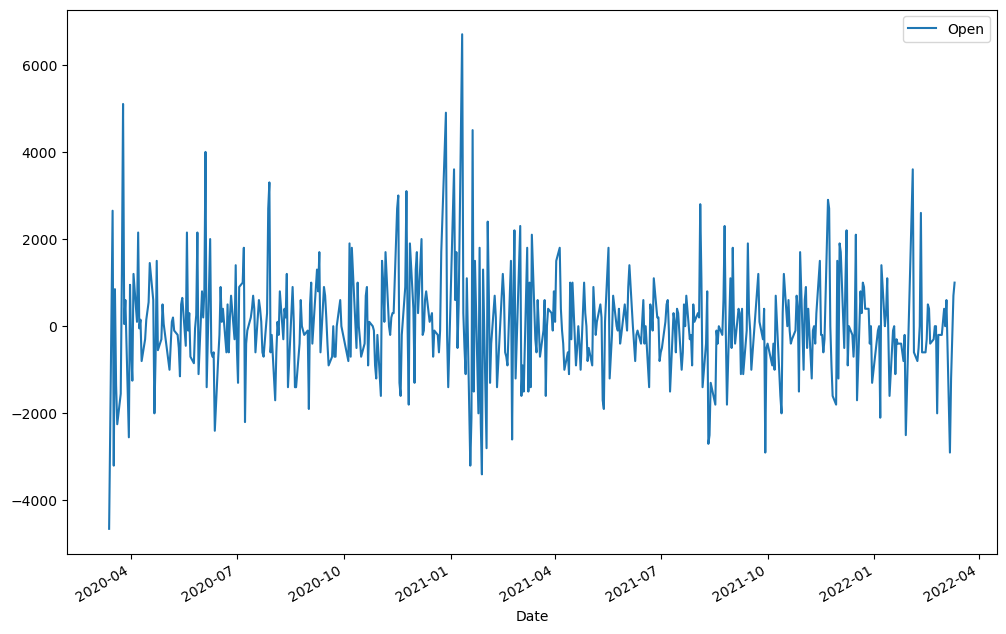

In [173]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

diff_data = training.diff(1) #차분 1진행. 
diff_data = diff_data.dropna() #결측값은 없애주고 
diff_data.plot()

In [174]:
adf = adfuller(diff_data)
print('ADF Statistic: {}'.format(adf[0]))
print('p-value : {}'.format(adf[1]))

ADF Statistic: -24.097765871112916
p-value : 0.0


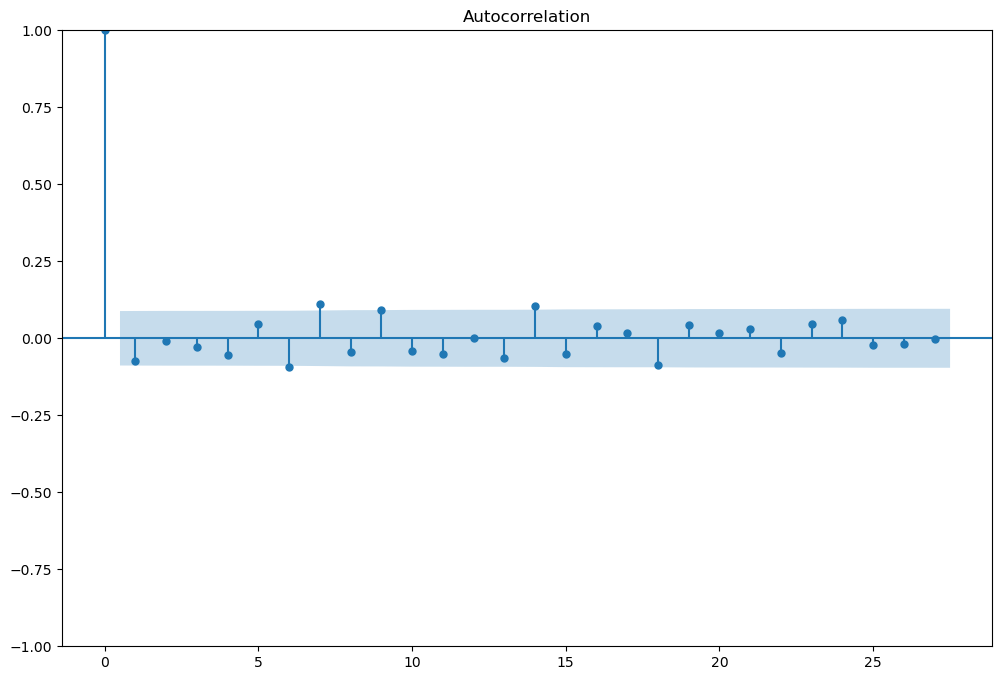

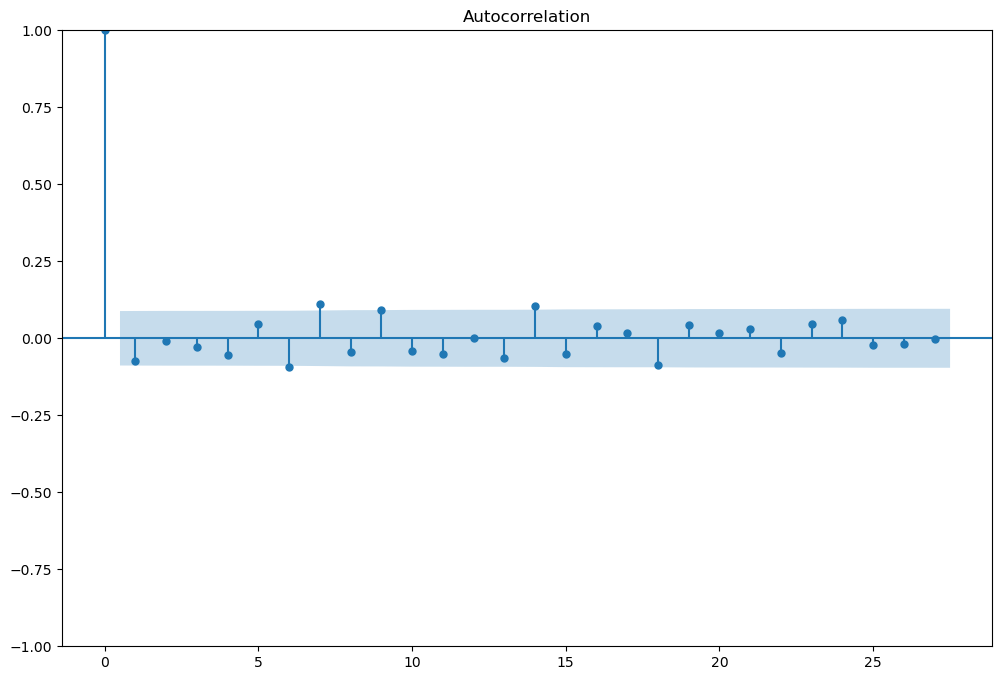

In [175]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #acf과 pacf를 그래프를 그려보자. 
import matplotlib.pyplot as plt

plot_acf(diff_data) #AR(p)의 값 확인 가능

C:\Users\diaky\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


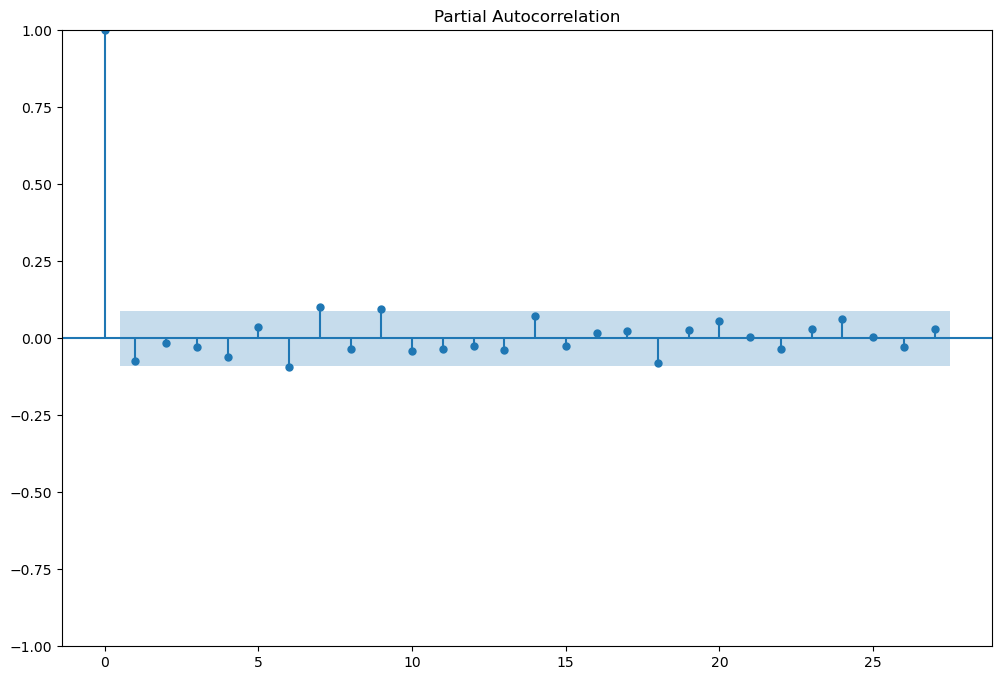

In [176]:
plot_pacf(diff_data) #MA(q)의 값 확인 가능

plt.show()

In [177]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(training, order=(3,0,6),trend='ct')
res = model.fit()
res.summary()

C:\Users\diaky\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\diaky\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\diaky\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\diaky\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Open   No. Observations:                  492
Model:                 ARIMA(3, 0, 6)   Log Likelihood               -4192.002
Date:                Sun, 12 Mar 2023   AIC                           8408.004
Time:                        23:21:08   BIC                           8458.386
Sample:                             0   HQIC                          8427.788
                                - 492                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.438e+04   1.69e+04      3.223      0.001    2.13e+04    8.75e+04
x1            59.8017     42.253      1.415      0.157     -23.012     142.615
ar.L1         -0.6945      0.058    -11.885      0.000      -0.809      -0.580
ar.L2          0.7733      0.026     29.259      0.000       0.721       0.825
ar.L3          0.8978      0.058     15.467      0.000       0.784       1.012
ma.L1          1.6469      0.069     23.993      0.000       1.512       1.781
ma.L2          0.7956      0.091      8.717      0.000       0.617       0.974
ma.L3         -0.1103      0.089     -1.238      0.216      -0.285       0.064
ma.L4         -0.1068      0.083     -1.290      0.197      -0.269       0.055
ma.L5         -0.0619      0.088     -0.700      0.484      -0.235       0.111
ma.L6         -0.0557      0.050     -1.121      0.262      -0.153       0.042
sigma2      1.391e+06   6.17e+04     22.542      0.000    1.27e+06    1.51e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               250.40
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.67
Prob(H) (two-sided):                  0.71   Kurtosis:                         6.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

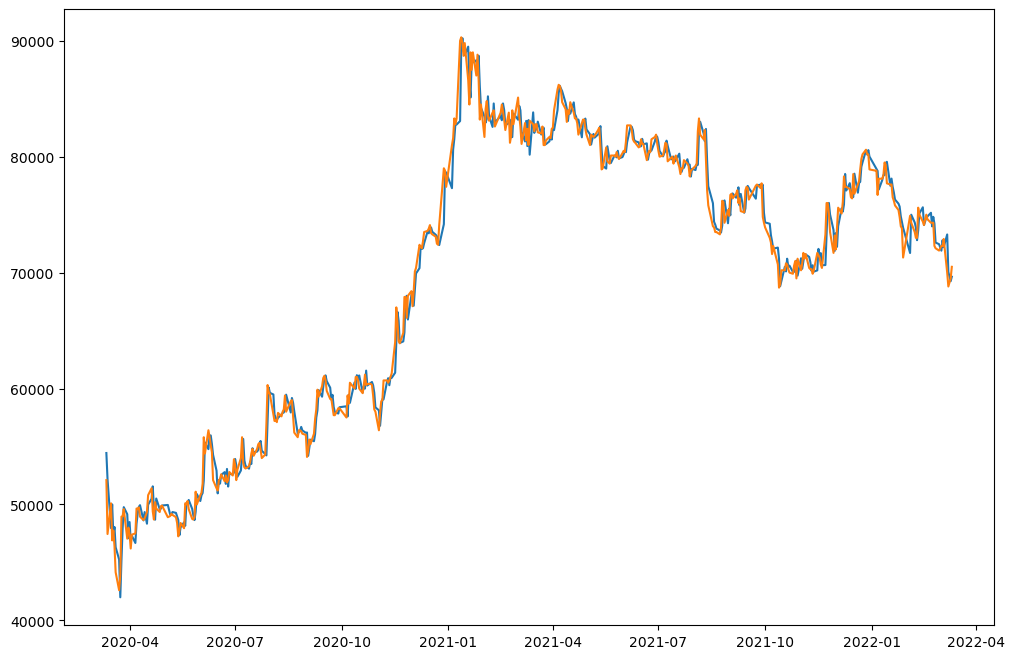

In [178]:
plt.plot(res.predict())
plt.plot(training)

In [121]:
!pip install pmdarima

In [180]:
from pmdarima import auto_arima #여러가지 값을 모두 다넣어보면서 aic값이 가장 작은 p,d,f값을 구한다. 

auto_model = auto_arima(training, start_p=0, d=1, start_q=0,
                        max_p=9, max_q=9, 
                        m=1,
                        seasonal=False, information_criterion='aic',
                        trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8391.662, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8378.173, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8379.215, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8390.111, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8378.997, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8377.533, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8379.532, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8379.618, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8380.091, Time=0.21 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8378.787, Time=0.48 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=8376.187, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=8378.011, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=8376.963, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=8378.189, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [181]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  492
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -4185.093
Date:                Sun, 12 Mar 2023   AIC                           8376.187
Time:                        23:24:14   BIC                           8388.776
Sample:                             0   HQIC                          8381.131
                                - 492                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5087      0.156     -3.261      0.001      -0.814      -0.203
ma.L1          0.4017      0.169      2.377      0.017       0.070       0.733
sigma2      1.464e+06    5.7e+04     25.669      0.000    1.35e+06    1.58e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.22   Jarque-Bera (JB):               296.17
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.84
Prob(H) (two-sided):                  0.96   Kurtosis:                         6.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [182]:
test

,Open
Date,
2022-03-14,70000.0
2022-03-15,70200.0
2022-03-16,70200.0
2022-03-17,70400.0
2022-03-18,70600.0
...,...
2023-03-06,61100.0
2023-03-07,61400.0
2023-03-08,60100.0


In [183]:
# 학습 데이터셋으로부터 test 데이터 길이만큼 예측
auto_pred_y= pd.DataFrame(auto_model.predict(n_periods=len(test)).values, 
                          index=test.index) 
auto_pred_y.columns = ['predicted_price']
auto_pred_y

C:\Users\diaky\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,predicted_price
Date,
2022-03-14,70421.770241
2022-03-15,70461.568567
2022-03-16,70441.321710
2022-03-17,70451.622023
2022-03-18,70446.381879
...,...
2023-03-06,70448.148822
2023-03-07,70448.148822
2023-03-08,70448.148822


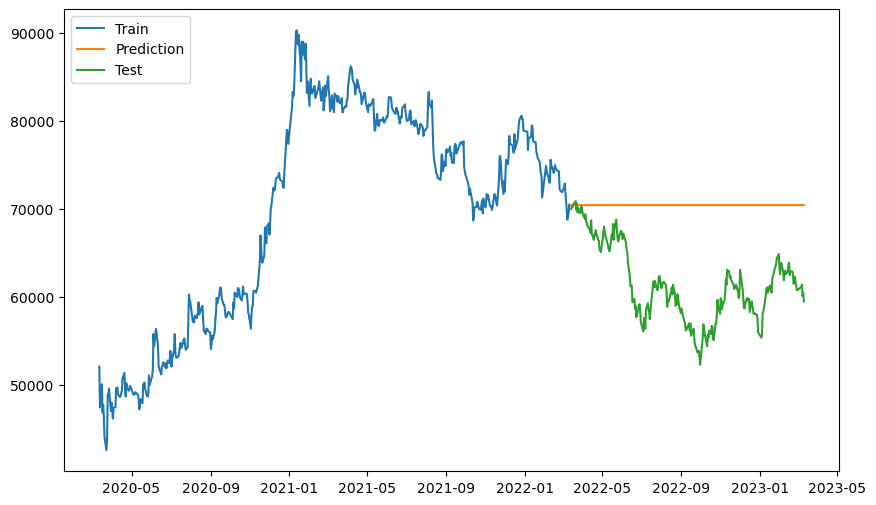

In [184]:
plt.figure(figsize=(10,6))
plt.plot(training, label="Train") # Train 데이터 
plt.plot(auto_pred_y, label="Prediction") # 모델이 예상한 그래프 
plt.plot(test, label="Test") # 실제 가격 그래프 
plt.legend(loc='upper left')
plt.show()

In [150]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("r2_score : ", r2_score(test_y, auto_pred_y))
RMSE = mean_squared_error(test_y, auto_pred_y)**0.5
print("RMSE : " , RMSE)

r2_score :  -4.554997891731684
RMSE :  10052.63525846816


- 예측이 제대로 안된 이유에 대해서 찾아보니,auto_arima 모형으로 찾은 ARIMA 모형은  상수항이 없는 임의 보행 모형 (Random Walk Model)을 따른다는 것을 알 수 있습니다.
- ϵt의 기댓값이 0이기 때문에 이부분을 0으로 대체하게 되고, 따라서 예측치들은 결국 마지막 관측치가 된다. 
- 삼성 주가 데이터의 경우 특정한 주기나 추세가 없었기 때문에, aic로 모형을 최적화하다보니 의미있는 ar이나 ma를 찾기 어려웠기 때문에 이를 최적 모형으로 선택한 것이다.. 
 
